# FAKE NEWS LSTM

## Imports

In [1]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
from collections import Counter
import re
import string

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords # remove stopword
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Vectorization classes

### Vocabulary

In [4]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """    
        # _token_to_idx for char_vocab:
        #   {'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'T': 4, 'o': 5, 't': 6, 'a': 7, ....., 'Á': 79}
        # _idx_to_token: 
        #   {0:'<MASK>'0, 1:'<UNK>', 2:'<BEGIN>',   3:'<END>',   4:'T',  5:'o',  6:'t',  7:'a',....., 79:'Á'}
            
        # _token_to_idx nationality_vocab: {'Arabic': 0, 'Chinese': 1, ..., 'Vietnamese': 17}
        # _idx_to_token:                   {0:'Arabic',  1:'Chinese', ...,  17:'Vietnamese'}

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         
                                                  
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [5]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token  # for paddding, e.g., 'McMahan' -> [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0]
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)           # mask_index is 0
        self.unk_index = self.add_token(self._unk_token)             # unk_index is 1
        self.begin_seq_index = self.add_token(self._begin_seq_token) # begin_seq_index is 2
        self.end_seq_index = self.add_token(self._end_seq_token)     # end_seq_index is 3

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

### Vectorizer

In [6]:
class NewsVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""   
    def __init__(self, news_vocab, category_vocab):
        self.news_vocab = news_vocab
        self.category_vocab = category_vocab

    def vectorize(self, text, vector_length=-1):
        """
        Args:
            text (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized text (numpy.array)
        """        
        indices = [self.news_vocab.begin_seq_index]
        indices.extend(self.news_vocab.lookup_token(token) 
                       for token in text.split(" "))
        indices.append(self.news_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)   # SurnameDataset._max_seq_length is 19 in current dataset.      
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.news_vocab.mask_index
        
        """    
        mask_index is 0
        unk_index is 1
        begin_seq_index is 2
        end_seq_index is 3
        
        When surname is "McMahan", M=5,c=6, a=7, h=8, and n=9 
        
        out_vector = [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0]
        len(indices) = 9      
        """ 
        #return out_vector, len(indices)
        return out_vector

    @classmethod
    def from_dataframe(cls, news_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        Args:
            news_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the NewsVectorizer
        """
        category_vocab = Vocabulary()
        for category in sorted(set(news_df.category)):
            category_vocab.add_token(category)

        word_counts = Counter()
        for text in news_df.text:
            for token in text.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
                    
        news_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                news_vocab.add_token(word)
        
        return cls(news_vocab, category_vocab)

### Dataset

In [7]:
def text_preprocessing(text):
    text = text.lower() # case folding
    text = re.sub('&\w*\;\w*', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(r"[^a-z]+", r" ", text) # Regulation, remove special charecters
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    lemmatizer=WordNetLemmatizer()
    # remove stopwords and lemmatization
    result = [lemmatizer.lemmatize(i) for i in tokens if not i in stop_words]
    result = result[:500]
    # bigram
    bigram_result = []
    bigram_list = ngrams(result, 2)
    for word_set in bigram_list:
        for word in word_set:
            bigram_result.append(word)
    return bigram_result

test_str_1 = "This is sentence to test the effect of preprocessing... Yeah~\nCool!fac  feae ge fe ga 🪣🛀🎀 ☏☢︎⏥␘⍎ (>╹ω╹<)喵"
test_str_2 = "Glaxo Settles Paxil 'Suicide Pill' Suit.  NEW YORK (Reuters) - GlaxoSmithKline Plc &lt;A HREF=http://www.investor.reuters.com/FullQuote.aspx?ticker=GSK.L target=/stocks/quickinfo/fullquote""&gt;GSK.L&lt;/A&gt; has agreed  to release all clinical studies of its drugs to settle a  lawsuit that accused it of withholding negative information  about the antidepressant Paxil, the New York Attorney General's  office said on Thursday."
list = text_preprocessing(test_str_2)
' '.join(list)

'glaxo settle settle paxil paxil suicide suicide pill pill suit suit new new york york reuters reuters glaxosmithkline glaxosmithkline plc plc href href target target stock stock quickinfo quickinfo fullquote fullquote l l agreed agreed release release clinical clinical study study drug drug settle settle lawsuit lawsuit accused accused withholding withholding negative negative information information antidepressant antidepressant paxil paxil new new york york attorney attorney general general office office said said thursday'

In [8]:
class NewsDataset(Dataset):
    def __init__(self, news_df, vectorizer):
        """
        Args:
            news_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.news_df = news_df 
        self._vectorizer = vectorizer
        
        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, news_df.text)) + 2

        self.train_df = self.news_df[self.news_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.news_df[self.news_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.news_df[self.news_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = self.train_df.category.value_counts().to_dict()  
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0]) 
        sorted_counts = sorted(class_counts.items(), key=sort_key)          
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32) 

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            news_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        news_df = pd.read_csv(news_csv)
        for index, text in enumerate(news_df.text):
            processed_list = text_preprocessing(text)
            news_df.text[index] = ' '.join(processed_list)
        train_news_df = news_df[news_df.split=='train']
        return cls(news_df, NewsVectorizer.from_dataframe(train_news_df))
        
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        
        news_vector = \
            self._vectorizer.vectorize(row.text, self._max_seq_length)
        
        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': news_vector, 
                'y_target': category_index} 
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size   

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Model: NewsClassifier

In [9]:
class NewsClassifier(nn.Module):
    #def __init__(self, num_embeddings, embedding_dim, output_dim, hidden_dim, num_layers, bidirectional, pretrained_embeddings=None, emb_freeze=True):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers, bidirectional, pretrained_embeddings=None, emb_freeze=True):
        super(NewsClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.embedding = nn.Embedding(num_embeddings, embedding_dim) 
            self.embedding.weight.requires_grad = True
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=emb_freeze) 
                                                                          
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        #self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.fc = nn.Linear(hidden_dim * 2)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        out = self.fc(hidden)
        return out

## Settings

### general utilities

In [10]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [11]:
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r", encoding='utf8') as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [12]:
args = Namespace(
    # Data and path information
    news_csv="../data/processed/fake_or_real_news_with_splits.csv",
    model_state_file="model_LSTM_Fake_News.pth",
    save_dir="../model_storage/Fake_News",
    # Model hyper parameter
    glove_filepath='../data/glove/glove.6B.100d.txt', 
    use_glove=True,
    embedding_size=100,
    rnn_hidden_size=128,
    bidirectional=True,
    num_layers=2,
    # Training hyper parameter
    num_epochs=100,
    learning_rate=0.001,
    batch_size=64,
    seed=1337,
    early_stopping_criteria=10,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    expand_filepaths_to_save_dir=True,
)
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: True


### Initializations

In [13]:
# create dataset and vectorizer
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.news_csv)

vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.news_vocab._token_to_idx.keys()  # 3409 unique words
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath,     # embeddings: (3409, 100)
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

C:\Users\dell\AppData\Local\Temp\ipykernel_22164\239385863.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df.text[index] = ' '.join(processed_list)
C:\Users\dell\AppData\Local\Temp\ipykernel_22164\239385863.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df.text[index] = ' '.join(processed_list)
C:\Users\dell\AppData\Local\Temp\ipykernel_22164\239385863.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df.t

Using pre-trained embeddings


In [14]:
dataset._max_seq_length # max sequence length

1000

In [15]:
vectorizer.news_vocab._token_to_idx

{'<MASK>': 0,
 '<UNK>': 1,
 '<BEGIN>': 2,
 '<END>': 3,
 'nothing': 4,
 'good': 5,
 'come': 6,
 'election': 7,
 'posted': 8,
 'november': 9,
 'charles': 10,
 'hugh': 11,
 'smith': 12,
 'overwhelming': 13,
 'consensus': 14,
 'across': 15,
 'political': 16,
 'spectrum': 17,
 'thing': 18,
 'go': 19,
 'like': 20,
 'country': 21,
 'deeply': 22,
 'divided': 23,
 'every': 24,
 'institution': 25,
 'two': 26,
 'party': 27,
 'mainstream': 28,
 'medium': 29,
 'department': 30,
 'justice': 31,
 'cover': 32,
 'ups': 33,
 'collusion': 34,
 'worse': 35,
 'whomever': 36,
 'win': 37,
 'enter': 38,
 'presidency': 39,
 'without': 40,
 'mandate': 41,
 'nation': 42,
 'corruption': 43,
 'require': 44,
 'hitting': 45,
 'bottom': 46,
 'alcoholic': 47,
 'drug': 48,
 'incapable': 49,
 'making': 50,
 'truly': 51,
 'positive': 52,
 'change': 53,
 'hit': 54,
 'absolute': 55,
 'tolerance': 56,
 'corrupt': 57,
 'system': 58,
 'poisoning': 59,
 'one': 60,
 'injection': 61,
 'cash': 62,
 'pay': 63,
 'play': 64,
 'time'

In [16]:
vectorizer.category_vocab._token_to_idx

{'FAKE': 0, 'REAL': 1}

## Training Routine

### Helper functions

In [17]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        #if loss_t >= loss_tm1:
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

### Grid Search

In [18]:
import time

#def train_for_fine_tune(embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, pretrained_embeddings, emb_freeze, batch_size):
def train_for_fine_tune(embedding_dim, hidden_dim, num_layers, bidirectional, pretrained_embeddings, emb_freeze, batch_size):
    set_seed_everywhere(args.seed, args.cuda)
    
    args.batch_size = batch_size
    classifier = NewsClassifier(embedding_dim=embedding_dim,          # e.g, 100
                                num_embeddings=len(vectorizer.news_vocab),  # e.g., 3409
                                #output_dim=output_dim,
                                hidden_dim=hidden_dim,
                                num_layers=num_layers,
                                bidirectional=bidirectional,
                                pretrained_embeddings=pretrained_embeddings)
    
    if pretrained_embeddings is None:
        is_pretrained_embeddings = False
    else:
        is_pretrained_embeddings = True
        
    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
        
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

    train_state = make_train_state(args)

    epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

    dataset.set_split('train')
    train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

    dataset.set_split('val')
    val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on

            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------
                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. compute the output
                y_pred = classifier(batch_dict['x_data']) # (batch, seq_len) -> (batch, num_classes)

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                optimizer.step()
                # -----------------------------------------
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # update bar
                train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                    epoch=epoch_index)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  classifier(batch_dict['x_data'])

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
                val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=classifier,
                                            train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()
    except KeyboardInterrupt:
        print("Exiting loop")
    
    acc = train_state['train_acc']
    val_acc = train_state['val_acc']
    loss = train_state['train_loss']
    val_loss = train_state['val_loss']

    epochs = range(1, len(acc) + 1)
    
    # compute the loss & accuracy on the test set using the best available model

    classifier.load_state_dict(torch.load(train_state['model_filename'])) # load the best model

    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    y_pred_list = []         # store predicted values for confusion matrix
    y_category_list = []  # ground truth value

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  classifier(batch_dict['x_data'])
        
        # store predicted values and ground truth values for calculating confusion matrix
        y_pred_list.extend(y_pred.max(dim=1)[1].cpu().numpy())
        y_category_list.extend(batch_dict['y_target'].cpu().numpy())
        
        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    
    return [embedding_dim, hidden_dim, num_layers, bidirectional, is_pretrained_embeddings, emb_freeze, batch_size, train_state['val_loss'][-1], train_state['val_acc'][-1], train_state['test_loss'], train_state['test_acc']]

def simple_grid_search(embedding_dim_values, hidden_dim_values, num_layers_values, bidirectional_values, batch_size_values, pretrained_embeddings_values, emb_freeze_values):    
    output_dim_value = 2
    
    print("embedding_dim_values:", embedding_dim_values)
    print("hidden_dim_values:", hidden_dim_values)
    print("batch_size_values: ", batch_size_values)
    print("num_layers_values: ", num_layers_values)
    print("bidirectional_values: ", bidirectional_values)
    
    best_by_val_loss = []
    best_by_val_acc = []
    best_by_test_loss = []
    best_by_test_acc = []
    
    log_path = 'Log_LSTM_Fake_News_320.txt'
    if os.path.exists(log_path):
        os.remove(log_path)
        
    with open(log_path, 'a') as log:
        for pretrained_embeddings_value in pretrained_embeddings_values:
            if pretrained_embeddings_value is not None:
                print("------------Use Pretrain------------")
                log.write("------------Use Pretrain------------\n")
                for emb_freeze_value in emb_freeze_values:
                    for bidirectional_value in bidirectional_values:
                        for hidden_dim_value in hidden_dim_values:
                            for num_layers_value in num_layers_values:
                                for batch_size_value in batch_size_values:
                                    print(f"------args-----\nbidirectional: {bidirectional_value} | hidden_dim: {hidden_dim_value} | num_layers: {num_layers_value} | batch_size: {batch_size_value} | emb_freeze: {emb_freeze_value}")
                                    log.write(f"------args-----\nbidirectional: {bidirectional_value} | hidden_dim: {hidden_dim_value} | num_layers: {num_layers_value} | batch_size: {batch_size_value} | emb_freeze: {emb_freeze_value}\n")
                                    start_time = time.time()
                                    result = train_for_fine_tune(100, hidden_dim_value, output_dim_value, num_layers_value, bidirectional_value, pretrained_embeddings_value, emb_freeze_value, batch_size_value)
                                    end_time = time.time()
                                    torch.cuda.empty_cache()
                                    if best_by_val_loss == [] or best_by_val_loss[7] > result[7]:
                                        best_by_val_loss = result
                                    if best_by_val_acc == [] or best_by_val_acc[8] < result[8]:
                                        best_by_val_acc = result
                                    if best_by_test_loss == [] or best_by_test_loss[9] > result[9]:
                                        best_by_test_loss = result
                                    if best_by_test_acc == [] or best_by_test_acc[10] < result[10]:
                                        best_by_test_acc = result
                                    elapsed_time = end_time - start_time
                                    print(f"------perf.-----\nval_loss: {result[7]} | val_acc: {result[8]}\ntest_loss: {result[9]} | test_acc: {result[10]}")
                                    print(f"took {elapsed_time:.2f} seconds.\nbest by va_loss: {best_by_val_loss[:7]} | best by va_acc: {best_by_val_acc[:7]}\nbest by te_loss: {best_by_test_loss[:7]} | best by te_acc: {best_by_test_acc[:7]}\n")
                                    log.write(f"------perf.-----\nval_loss: {result[7]} | val_acc: {result[8]}\ntest_loss: {result[9]} | test_acc: {result[10]}\n")
                                    log.write(f"took {elapsed_time:.2f} seconds.\nbest by va_loss: {best_by_val_loss[:7]} | best by va_acc: {best_by_val_acc[:7]}\nbest by te_loss: {best_by_test_loss[:7]} | best by te_acc: {best_by_test_acc[:7]}\n\n")
            else:
                print("------Not Use Pretrain------")
                log.write("------------Not Use Pretrain------------\n")
                for bidirectional_value in bidirectional_values:
                    for embedding_dim_value in embedding_dim_values:
                        for hidden_dim_value in hidden_dim_values:
                            for num_layers_value in num_layers_values:
                                for batch_size_value in batch_size_values:
                                    print(f"------args-----\nbidirectional: {bidirectional_value} | embedding_dim: {embedding_dim_value} | hidden_dim: {hidden_dim_value} | num_layers: {num_layers_value} | batch_size: {batch_size_value}")
                                    log.write(f"------args-----\nbidirectional: {bidirectional_value} | embedding_dim: {embedding_dim_value} | hidden_dim: {hidden_dim_value} | num_layers: {num_layers_value} | batch_size: {batch_size_value}\n")
                                    start_time = time.time()
                                    result = train_for_fine_tune(embedding_dim_value, hidden_dim_value, output_dim_value, num_layers_value, bidirectional_value, pretrained_embeddings_value, True, batch_size_value)
                                    end_time = time.time()
                                    torch.cuda.empty_cache()
                                    if best_by_val_loss == [] or best_by_val_loss[7] > result[7]:
                                        best_by_val_loss = result
                                    if best_by_val_acc == [] or best_by_val_acc[8] < result[8]:
                                        best_by_val_acc = result
                                    if best_by_test_loss == [] or best_by_test_loss[9] > result[9]:
                                        best_by_test_loss = result
                                    if best_by_test_acc == [] or best_by_test_acc[10] < result[10]:
                                        best_by_test_acc = result
                                    elapsed_time = end_time - start_time
                                    print(f"------perf.-----\nval_loss: {result[7]} | val_acc: {result[8]}\ntest_loss: {result[9]} | test_acc: {result[10]}")
                                    print(f"took {elapsed_time:.2f} seconds.\nbest by va_loss: {best_by_val_loss[:7]} | best by va_acc: {best_by_val_acc[:7]}\nbest by te_loss: {best_by_test_loss[:7]} | best by te_acc: {best_by_test_acc[:7]}\n")
                                    log.write(f"------perf.-----\nval_loss: {result[7]} | val_acc: {result[8]}\ntest_loss: {result[9]} | test_acc: {result[10]}\n")
                                    log.write(f"took {elapsed_time:.2f} seconds.\nbest by va_loss: {best_by_val_loss[:7]} | best by va_acc: {best_by_val_acc[:7]}\nbest by te_loss: {best_by_test_loss[:7]} | best by te_acc: {best_by_test_acc[:7]}\n\n")

        print("--------------Best Val Loss--------------")
        print(f"embedding_dim: {best_by_val_loss[0]}\nhidden_dim: {best_by_val_loss[1]}\nnum_layers: {best_by_val_loss[2]}\nbidirectional: {best_by_val_loss[3]}\nis_pretrained_embeddings: {best_by_val_loss[4]}\nemb_freeze: {best_by_val_loss[5]}\nbatch_size：{best_by_val_loss[6]}\n")
        
        print("--------------Best Val Acc--------------")
        print(f"embedding_dim: {best_by_val_acc[0]}\nhidden_dim: {best_by_val_acc[1]}\nnum_layers: {best_by_val_acc[2]}\nbidirectional: {best_by_val_acc[3]}\nis_pretrained_embeddings: {best_by_val_acc[4]}\nemb_freeze: {best_by_val_acc[5]}\nbatch_size：{best_by_val_acc[6]}\n")
        
        print("--------------Best Test Loss--------------")
        print(f"embedding_dim: {best_by_test_loss[0]}\nhidden_dim: {best_by_test_loss[1]}\nnum_layers: {best_by_test_loss[2]}\nbidirectional: {best_by_test_loss[3]}\nis_pretrained_embeddings: {best_by_test_loss[4]}\nemb_freeze: {best_by_test_loss[5]}\nbatch_size：{best_by_test_loss[6]}\n")
        
        print("--------------Best Test Acc--------------")
        print(f"embedding_dim: {best_by_test_acc[0]}\nhidden_dim: {best_by_test_acc[1]}\nnum_layers: {best_by_test_acc[2]}\nbidirectional: {best_by_test_acc[3]}\nis_pretrained_embeddings: {best_by_test_acc[4]}\nemb_freeze: {best_by_test_acc[5]}\nbatch_size：{best_by_test_acc[6]}\n")

        log.write("--------------Best Val Loss--------------\n")
        log.write(f"embedding_dim: {best_by_val_loss[0]}\nhidden_dim: {best_by_val_loss[1]}\nnum_layers: {best_by_val_loss[2]}\nbidirectional: {best_by_val_loss[3]}\nis_pretrained_embeddings: {best_by_val_loss[4]}\nemb_freeze: {best_by_val_loss[5]}\nbatch_size：{best_by_val_loss[6]}\n\n")
        
        log.write("--------------Best Val Acc--------------\n")
        log.write(f"embedding_dim: {best_by_val_acc[0]}\nhidden_dim: {best_by_val_acc[1]}\nnum_layers: {best_by_val_acc[2]}\nbidirectional: {best_by_val_acc[3]}\nis_pretrained_embeddings: {best_by_val_acc[4]}\nemb_freeze: {best_by_val_acc[5]}\nbatch_size：{best_by_val_acc[6]}\n\n")
        
        log.write("--------------Best Test Loss--------------\n")
        log.write(f"embedding_dim: {best_by_test_loss[0]}\nhidden_dim: {best_by_test_loss[1]}\nnum_layers: {best_by_test_loss[2]}\nbidirectional: {best_by_test_loss[3]}\nis_pretrained_embeddings: {best_by_test_loss[4]}\nemb_freeze: {best_by_test_loss[5]}\nbatch_size：{best_by_test_loss[6]}\n\n")
        
        log.write("--------------Best Test Acc--------------\n")
        log.write(f"embedding_dim: {best_by_test_acc[0]}\nhidden_dim: {best_by_test_acc[1]}\nnum_layers: {best_by_test_acc[2]}\nbidirectional: {best_by_test_acc[3]}\nis_pretrained_embeddings: {best_by_test_acc[4]}\nemb_freeze: {best_by_test_acc[5]}\nbatch_size：{best_by_test_acc[6]}\n\n")

#### Search Range

In [19]:
embedding_dim_values = [i for i in range(64, 161, 32)]
hidden_dim_values = [i for i in range(320, 513, 64)]
batch_size_values = [i for i in range(64, 193, 32)]
num_layers_values = [1, 2, 3]
bidirectional_values = [True]
pretrained_embeddings_values =[embeddings]
emb_freeze_values = [False]

simple_grid_search(embedding_dim_values, hidden_dim_values, num_layers_values, bidirectional_values, batch_size_values, pretrained_embeddings_values, emb_freeze_values)

embedding_dim_values: [64, 96, 128, 160]
hidden_dim_values: [320, 384, 448, 512]
batch_size_values:  [64, 96, 128, 160, 192]
num_layers_values:  [1, 2, 3]
bidirectional_values:  [True]
------------Use Pretrain------------
------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 1 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.5551228927714484 | val_acc: 86.38392857142857
test_loss: 0.34298089678798405 | test_acc: 85.71428571428572
took 113.93 seconds.
best by va_loss: [100, 320, 1, True, True, False, 64] | best by va_acc: [100, 320, 1, True, True, False, 64]
best by te_loss: [100, 320, 1, True, True, False, 64] | best by te_acc: [100, 320, 1, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 1 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4334136976136101 | val_acc: 85.64814814814815
test_loss: 0.35263756414254505 | test_acc: 86.11111111111111
took 126.60 seconds.
best by va_loss: [100, 320, 1, True, True, False, 96] | best by va_acc: [100, 320, 1, True, True, False, 64]
best by te_loss: [100, 320, 1, True, True, False, 64] | best by te_acc: [100, 320, 1, True, True, False, 96]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 1 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.3965220536504473 | val_acc: 85.37946428571428
test_loss: 0.3529213262455804 | test_acc: 85.04464285714286
took 117.56 seconds.
best by va_loss: [100, 320, 1, True, True, False, 128] | best by va_acc: [100, 320, 1, True, True, False, 64]
best by te_loss: [100, 320, 1, True, True, False, 64] | best by te_acc: [100, 320, 1, True, True, False, 96]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 1 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.38376633524894715 | val_acc: 84.5
test_loss: 0.3395725071430206 | test_acc: 85.125
took 86.80 seconds.
best by va_loss: [100, 320, 1, True, True, False, 160] | best by va_acc: [100, 320, 1, True, True, False, 64]
best by te_loss: [100, 320, 1, True, True, False, 160] | best by te_acc: [100, 320, 1, True, True, False, 96]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 1 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.436026856303215 | val_acc: 82.55208333333334
test_loss: 0.3593134135007858 | test_acc: 85.9375
took 75.99 seconds.
best by va_loss: [100, 320, 1, True, True, False, 160] | best by va_acc: [100, 320, 1, True, True, False, 64]
best by te_loss: [100, 320, 1, True, True, False, 160] | best by te_acc: [100, 320, 1, True, True, False, 96]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 2 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.40292350202798843 | val_acc: 92.07589285714286
test_loss: 0.2698485766138349 | test_acc: 89.73214285714285
took 366.00 seconds.
best by va_loss: [100, 320, 1, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 2 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.6787627405590482 | val_acc: 86.1111111111111
test_loss: 0.37328790624936414 | test_acc: 83.68055555555557
took 255.98 seconds.
best by va_loss: [100, 320, 1, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 2 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4804791126932417 | val_acc: 86.83035714285714
test_loss: 0.3123340904712677 | test_acc: 87.72321428571429
took 183.11 seconds.
best by va_loss: [100, 320, 1, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 2 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.3356183171272278 | val_acc: 86.625
test_loss: 0.3277482926845551 | test_acc: 87.0
took 274.06 seconds.
best by va_loss: [100, 320, 2, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 2 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.44299615919589996 | val_acc: 87.36979166666666
test_loss: 0.32688596844673157 | test_acc: 86.71875
took 123.02 seconds.
best by va_loss: [100, 320, 2, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 3 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.33310227628265104 | val_acc: 88.28125000000001
test_loss: 0.34950995658125195 | test_acc: 87.16517857142857
took 710.31 seconds.
best by va_loss: [100, 320, 3, True, True, False, 64] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 3 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.39983287784788346 | val_acc: 85.41666666666667
test_loss: 0.4005435009797414 | test_acc: 83.91203703703704
took 360.13 seconds.
best by va_loss: [100, 320, 3, True, True, False, 64] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 3 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.3853249933038439 | val_acc: 86.27232142857143
test_loss: 0.33723436083112446 | test_acc: 86.83035714285714
took 214.24 seconds.
best by va_loss: [100, 320, 3, True, True, False, 64] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 3 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.2819243401288986 | val_acc: 89.75
test_loss: 0.30735284090042114 | test_acc: 87.375
took 274.10 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 320 | num_layers: 3 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.5012941956520081 | val_acc: 87.36979166666667
test_loss: 0.3588692545890808 | test_acc: 87.36979166666666
took 177.35 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 1 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.48573870744024006 | val_acc: 87.27678571428571
test_loss: 0.36608983469860895 | test_acc: 84.04017857142856
took 92.23 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 1 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.44020624293221366 | val_acc: 85.99537037037037
test_loss: 0.36304496228694916 | test_acc: 86.11111111111111
took 84.99 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 1 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.47425848671368187 | val_acc: 81.91964285714285
test_loss: 0.42356182847704205 | test_acc: 83.81696428571429
took 91.02 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 1 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.41699807047843934 | val_acc: 85.375
test_loss: 0.384515768289566 | test_acc: 85.25
took 53.29 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 1 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.3986283466219902 | val_acc: 84.765625
test_loss: 0.39027830958366394 | test_acc: 84.11458333333333
took 57.82 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 2 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.3384527090404715 | val_acc: 88.50446428571428
test_loss: 0.301878391632012 | test_acc: 87.72321428571429
took 223.10 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 2 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.651340881983439 | val_acc: 85.99537037037037
test_loss: 0.4004854659239451 | test_acc: 84.02777777777777
took 170.63 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 2 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.38833900434630253 | val_acc: 87.27678571428571
test_loss: 0.35027493323598585 | test_acc: 84.70982142857143
took 142.43 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 2 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.44708544611930845 | val_acc: 85.5
test_loss: 0.38194172978401186 | test_acc: 85.875
took 172.57 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 2 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.44811996072530746 | val_acc: 85.80729166666666
test_loss: 0.35552576184272766 | test_acc: 84.89583333333333
took 96.71 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 3 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.3201735551868166 | val_acc: 90.73660714285714
test_loss: 0.3127997842218194 | test_acc: 89.17410714285715
took 622.52 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 3 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.5540211929215325 | val_acc: 86.92129629629629
test_loss: 0.36324163609080845 | test_acc: 84.14351851851853
took 327.58 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 3 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.36413615516253883 | val_acc: 89.39732142857143
test_loss: 0.32858686787741526 | test_acc: 86.27232142857143
took 292.67 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 3 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4616782903671265 | val_acc: 87.25
test_loss: 0.3566905796527863 | test_acc: 85.75
took 189.89 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 384 | num_layers: 3 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.34158922731876373 | val_acc: 86.97916666666667
test_loss: 0.33877937495708466 | test_acc: 86.06770833333334
took 250.69 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 1 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.48579762343849453 | val_acc: 86.38392857142857
test_loss: 0.37166773208550047 | test_acc: 84.04017857142857
took 86.86 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 1 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.46316085921393496 | val_acc: 86.1111111111111
test_loss: 0.3361591630511814 | test_acc: 86.22685185185185
took 89.55 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 1 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4829921041216169 | val_acc: 84.15178571428572
test_loss: 0.41557214089802336 | test_acc: 81.91964285714286
took 86.35 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 1 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4133503496646881 | val_acc: 81.25
test_loss: 0.3965472340583801 | test_acc: 83.375
took 106.90 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 1 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.44603927433490753 | val_acc: 84.11458333333334
test_loss: 0.3947451189160347 | test_acc: 83.203125
took 65.60 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 2 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.431808616699917 | val_acc: 89.28571428571428
test_loss: 0.349015012383461 | test_acc: 86.60714285714286
took 272.57 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 2 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.5226666198836432 | val_acc: 85.18518518518518
test_loss: 0.36800142957104576 | test_acc: 86.3425925925926
took 238.03 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 2 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.5453298134463174 | val_acc: 75.55803571428572
test_loss: 0.4553865236895425 | test_acc: 79.24107142857143
took 94.48 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 2 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.3762040972709656 | val_acc: 87.375
test_loss: 0.40368103981018066 | test_acc: 84.75
took 197.57 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 2 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4088250994682312 | val_acc: 86.71874999999999
test_loss: 0.3377915620803833 | test_acc: 85.546875
took 108.74 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 3 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.28727735951542854 | val_acc: 89.50892857142857
test_loss: 0.300215408205986 | test_acc: 88.83928571428572
took 1004.40 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 3 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.3997453384929233 | val_acc: 82.29166666666667
test_loss: 0.3657642006874084 | test_acc: 83.68055555555556
took 303.52 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 3 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.37750438281467985 | val_acc: 86.16071428571428
test_loss: 0.3486522989613669 | test_acc: 85.37946428571429
took 479.22 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 3 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.32240086793899536 | val_acc: 86.5
test_loss: 0.3315874457359314 | test_acc: 86.75
took 2157.91 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 448 | num_layers: 3 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.30698496103286743 | val_acc: 87.5
test_loss: 0.33736277371644974 | test_acc: 87.109375
took 1202.55 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 1 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.5459384481821741 | val_acc: 87.16517857142857
test_loss: 0.3829843763794218 | test_acc: 82.14285714285714
took 100.01 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 1 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4666074646843804 | val_acc: 84.49074074074073
test_loss: 0.373127732012007 | test_acc: 84.37499999999999
took 81.31 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 1 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.5122429175036295 | val_acc: 85.04464285714285
test_loss: 0.3707713527338845 | test_acc: 85.71428571428571
took 80.74 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 1 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.37067191004753114 | val_acc: 86.125
test_loss: 0.35395635962486266 | test_acc: 86.0
took 78.77 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 1 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.46529626101255417 | val_acc: 83.46354166666666
test_loss: 0.40113064646720886 | test_acc: 83.85416666666666
took 66.84 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 2 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4704812892845699 | val_acc: 83.70535714285714
test_loss: 0.3776682721717017 | test_acc: 83.70535714285714
took 303.22 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 2 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4732010397646162 | val_acc: 86.9212962962963
test_loss: 0.35135288702117073 | test_acc: 85.41666666666667
took 183.54 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 2 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.31790706302438465 | val_acc: 88.28125
test_loss: 0.3201624687228884 | test_acc: 87.16517857142857
took 225.14 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 2 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.47710137367248534 | val_acc: 87.0
test_loss: 0.38495169281959535 | test_acc: 84.0
took 205.12 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 2 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4916011765599251 | val_acc: 77.99479166666666
test_loss: 0.49049560725688934 | test_acc: 76.30208333333333
took 237.67 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 3 | batch_size: 64 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.29977607620613916 | val_acc: 87.83482142857143
test_loss: 0.3068103321960994 | test_acc: 87.38839285714286
took 1622.00 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 3 | batch_size: 96 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/46 [00:00<?, ?it/s]

split=val:   0%|          | 0/9 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4457499782244364 | val_acc: 86.9212962962963
test_loss: 0.3499097294277615 | test_acc: 87.38425925925927
took 412.67 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 3 | batch_size: 128 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/34 [00:00<?, ?it/s]

split=val:   0%|          | 0/7 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.4537574563707624 | val_acc: 86.27232142857143
test_loss: 0.38573009414332254 | test_acc: 84.375
took 700.05 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 3 | batch_size: 160 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/27 [00:00<?, ?it/s]

split=val:   0%|          | 0/5 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.35848965048789977 | val_acc: 85.875
test_loss: 0.35909131169319153 | test_acc: 85.25
took 1308.99 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

------args-----
bidirectional: True | hidden_dim: 512 | num_layers: 3 | batch_size: 192 | emb_freeze: False


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/23 [00:00<?, ?it/s]

split=val:   0%|          | 0/4 [00:00<?, ?it/s]

------perf.-----
val_loss: 0.46870337426662445 | val_acc: 88.02083333333333
test_loss: 0.38152019679546356 | test_acc: 86.06770833333334
took 852.39 seconds.
best by va_loss: [100, 320, 3, True, True, False, 160] | best by va_acc: [100, 320, 2, True, True, False, 64]
best by te_loss: [100, 320, 2, True, True, False, 64] | best by te_acc: [100, 320, 2, True, True, False, 64]

--------------Best Val Loss--------------
embedding_dim: 100
hidden_dim: 320
num_layers: 3
bidirectional: True
is_pretrained_embeddings: True
emb_freeze: False
batch_size：160

--------------Best Val Acc--------------
embedding_dim: 100
hidden_dim: 320
num_layers: 2
bidirectional: True
is_pretrained_embeddings: True
emb_freeze: False
batch_size：64

--------------Best Test Loss--------------
embedding_dim: 100
hidden_dim: 320
num_layers: 2
bidirectional: True
is_pretrained_embeddings: True
emb_freeze: False
batch_size：64

--------------Best Test Acc--------------
embedding_dim: 100
hidden_dim: 320
num_layers: 2
bidir

In [41]:
args.embedding_dim = 100
args.hidden_dim = 320
args.num_layers = 2
args.bidirectional = True
args.use_glove = True
args.emb_freeze = False
args.batch_size = 64
#args.bidirectional=True

In [42]:
# Use GloVe or randomly initialized embeddings
set_seed_everywhere(args.seed, args.cuda)

if args.use_glove:
    words = vectorizer.news_vocab._token_to_idx.keys()  # 3409 unique words
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath,     # embeddings: (3409, 100)
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings


In [44]:
classifier = NewsClassifier(embedding_dim=args.embedding_dim,          # e.g, 100
                            num_embeddings=len(vectorizer.news_vocab),  # e.g., 3409
                            output_dim=args.output_dim,
                            hidden_dim=args.hidden_dim,
                            num_layers=args.num_layers,
                            bidirectional=args.bidirectional,
                            pretrained_embeddings=embeddings)

### Training loop

In [45]:
set_seed_everywhere(args.seed, args.cuda)

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'])  
            
            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)


        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 1
        val_bar.n = 1
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/69 [00:00<?, ?it/s]

split=val:   0%|          | 0/14 [00:00<?, ?it/s]

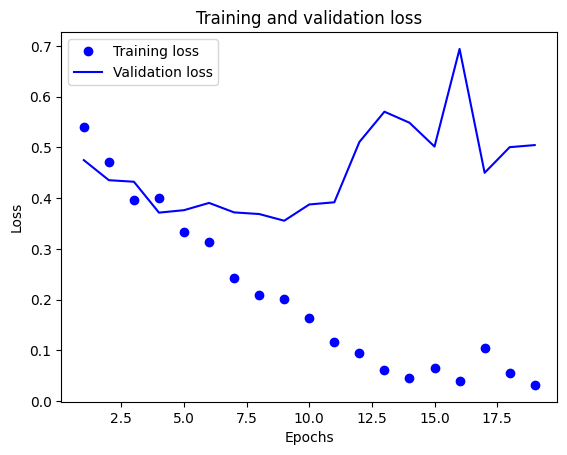

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

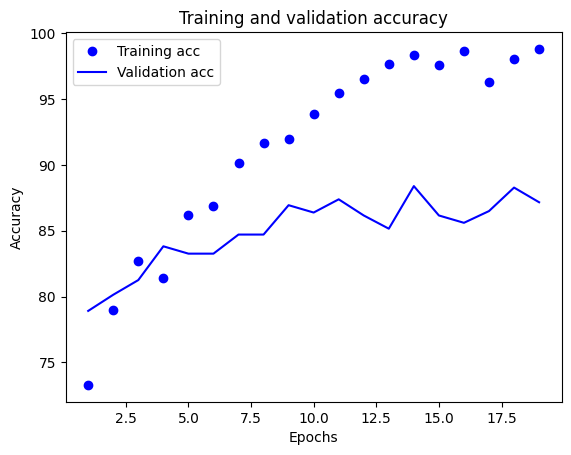

In [31]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
# compute the loss & accuracy on the test set using the best available model
set_seed_everywhere(args.seed, args.cuda)

classifier.load_state_dict(torch.load(train_state['model_filename'])) # load the best model

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []         # store predicted values for confusion matrix
y_category_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'])
    
    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend(y_pred.max(dim=1)[1].cpu().numpy())
    y_category_list.extend(batch_dict['y_target'].cpu().numpy())
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [33]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.36963365226984024;
Test Accuracy: 86.27232142857142


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
category_classes = []
for i in range(len(dataset._vectorizer.category_vocab)):
    category_classes.append(dataset._vectorizer.category_vocab.lookup_index(i))
print(category_classes)

['FAKE', 'REAL']


In [35]:
import pandas as pd

cm = confusion_matrix(y_category_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=category_classes, columns=category_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       FAKE  REAL
Predicted            
FAKE        388    65
REAL         58   385


In [36]:
print(classification_report(y_category_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       446
           1       0.87      0.86      0.86       450

    accuracy                           0.86       896
   macro avg       0.86      0.86      0.86       896
weighted avg       0.86      0.86      0.86       896



### Inference

In [37]:
# Preprocess the reviews
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [38]:
def predict_category(title, classifier, vectorizer, max_length):
    """Predict a News category for a new title
    
    Args:
        title (str): a raw title string
        classifier (NewsClassifier): an instance of the trained classifier
        vectorizer (NewsVectorizer): the corresponding vectorizer
        max_length (int): the max sequence length
            Note: CNNs are sensitive to the input data tensor size. 
                  This ensures to keep it the same size as the training data
    """
    title = preprocess_text(title)
    vectorized_title = \
        torch.tensor(vectorizer.vectorize(title, vector_length=max_length))
    result = classifier(vectorized_title.unsqueeze(0))
    probability_values, indices = result.max(dim=1)
    predicted_category = vectorizer.category_vocab.lookup_index(indices.item())

    return {'category': predicted_category, 
            'probability': probability_values.item()}

In [39]:
def get_samples():
    samples = {}
    for cat in dataset.val_df.category.unique():
        samples[cat] = dataset.val_df.text[dataset.val_df.category==cat].tolist()[:5]
    return samples

val_samples = get_samples() # first 5 titles of each category from validation dataset

In [40]:
#title = input("Enter a news title to classify: ")
classifier = classifier.to("cpu")

for truth, sample_group in val_samples.items():
    print(f"True Category: {truth}")
    print("="*30)
    for sample in sample_group:
        prediction = predict_category(sample, classifier, 
                                      vectorizer, dataset._max_seq_length)
        print("Prediction: {} (p={:0.2f})".format(prediction['category'],
                                                  prediction['probability']))
        print("\t + Sample: {}".format(sample))
    print("-"*30 + "\n")

True Category: FAKE
Prediction: FAKE (p=1.17)
	 + Sample: hillary clinton clinton postapocalyptic postapocalyptic hellscape hellscape plan plan hillary hillary clinton clinton postapocalyptic postapocalyptic hellscape hellscape plan plan important important avoid avoid age age peace peace hillary hillary clinton clinton postapocalyptic postapocalyptic hellscape hellscape plan plan b b look look email email even even com com wrong wrong comdingdangaramaramaflimflam comdingdangaramaramaflimflam mail mail question question comment comment site site godlike godlike production production glp glp registered registered trademark trademark zero zero point point ltd ltd godlike godlike website website design design copyright copyright godlikeproductions godlikeproductions com com page page generated generated query
Prediction: FAKE (p=1.30)
	 + Sample: russophobia war war party party propaganda propaganda information information russophobia russophobia war war party party propagandathe propagan